In [3]:
import pandas as pd 

In [4]:
data = pd.read_csv('kc_house_data.csv', index_col=False)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class OutlierDetector:
    def __init__(self, data):
        """
        Initialize the OutlierDetector with a dataset
        
        Parameters:
        data: pandas DataFrame or path to CSV file
        """
        if isinstance(data, str):
            self.df = pd.read_csv(data)
        else:
            self.df = data.copy()
        
        # Select only numeric columns
        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Found {len(self.numeric_cols)} numeric columns: {self.numeric_cols}")
    
    def z_score_outliers(self, threshold=3):
        """
        Detect outliers using Z-score method
        
        Parameters:
        threshold: Z-score threshold (default: 3)
        
        Returns:
        Dictionary with outlier indices for each column
        """
        outliers = {}
        
        for col in self.numeric_cols:
            z_scores = np.abs(stats.zscore(self.df[col].dropna()))
            outlier_indices = np.where(z_scores > threshold)[0]
            outliers[col] = outlier_indices
            
        return outliers
    
    def iqr_outliers(self):
        """
        Detect outliers using Interquartile Range (IQR) method
        
        Returns:
        Dictionary with outlier indices for each column
        """
        outliers = {}
        
        for col in self.numeric_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_indices = self.df[(self.df[col] < lower_bound) | 
                                    (self.df[col] > upper_bound)].index.tolist()
            outliers[col] = outlier_indices
            
        return outliers
    
    def isolation_forest_outliers(self, contamination=0.1):
        """
        Detect outliers using Isolation Forest
        
        Parameters:
        contamination: Expected proportion of outliers (default: 0.1)
        
        Returns:
        Array of outlier indices
        """
        # Prepare data
        data_clean = self.df[self.numeric_cols].dropna()
        
        # Standardize the data
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_clean)
        
        # Apply Isolation Forest
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outlier_labels = iso_forest.fit_predict(data_scaled)
        
        # Get outlier indices
        outlier_indices = data_clean[outlier_labels == -1].index.tolist()
        
        return outlier_indices
    
    def plot_outliers(self, method='iqr', figsize=(15, 10)):
        """
        Create visualizations for outlier detection
        
        Parameters:
        method: 'iqr', 'zscore', or 'isolation'
        figsize: Figure size tuple
        """
        n_cols = len(self.numeric_cols)
        n_rows = (n_cols + 2) // 3
        
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        if method == 'iqr':
            outliers = self.iqr_outliers()
        elif method == 'zscore':
            outliers = self.z_score_outliers()
        
        for i, col in enumerate(self.numeric_cols):
            if i < len(axes):
                # Box plot
                axes[i].boxplot(self.df[col].dropna())
                axes[i].set_title(f'{col} - Box Plot')
                axes[i].set_ylabel('Value')
                
                # Highlight outliers
                if method in ['iqr', 'zscore']:
                    outlier_values = self.df.loc[outliers[col], col]
                    axes[i].scatter([1] * len(outlier_values), outlier_values, 
                                  color='red', s=50, alpha=0.7, label='Outliers')
                    axes[i].legend()
        
        # Hide empty subplots
        for i in range(len(self.numeric_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def plot_distribution_with_outliers(self, column, method='iqr'):
        """
        Plot distribution of a specific column with outliers highlighted
        
        Parameters:
        column: Column name to plot
        method: Outlier detection method ('iqr' or 'zscore')
        """
        if column not in self.numeric_cols:
            print(f"Column '{column}' not found in numeric columns")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 20))
        
        # Get outliers
        if method == 'iqr':
            outliers = self.iqr_outliers()
        elif method == 'zscore':
            outliers = self.z_score_outliers()
        
        outlier_indices = outliers[column]
        
        # Histogram
        ax1.hist(self.df[column].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.axvline(self.df[column].mean(), color='red', linestyle='--', label='Mean')
        ax1.axvline(self.df[column].median(), color='green', linestyle='--', label='Median')
        ax1.set_title(f'Distribution of {column}')
        ax1.set_xlabel(column)
        ax1.set_ylabel('Frequency')
        ax1.legend()
        
        # Box plot with outliers
        ax2.boxplot(self.df[column].dropna())
        outlier_values = self.df.loc[outlier_indices, column]
        ax2.scatter([1] * len(outlier_values), outlier_values, 
                   color='red', s=50, alpha=0.7, label=f'Outliers ({len(outlier_values)})')
        ax2.set_title(f'{column} - Box Plot with Outliers')
        ax2.set_ylabel('Value')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def summary_report(self):
        """
        Generate a comprehensive outlier detection report
        """
        print("=== OUTLIER DETECTION REPORT ===\n")
        
        # Dataset info
        print(f"Dataset shape: {self.df.shape}")
        print(f"Numeric columns: {len(self.numeric_cols)}")
        print(f"Columns analyzed: {self.numeric_cols}\n")
        
        # Z-score outliers
        print("1. Z-SCORE METHOD (threshold = 3):")
        z_outliers = self.z_score_outliers()
        for col, indices in z_outliers.items():
            print(f"   {col}: {len(indices)} outliers ({len(indices)/len(self.df)*100:.2f}%)")
        
        print("\n2. IQR METHOD:")
        iqr_outliers = self.iqr_outliers()
        for col, indices in iqr_outliers.items():
            print(f"   {col}: {len(indices)} outliers ({len(indices)/len(self.df)*100:.2f}%)")
        
        print("\n3. ISOLATION FOREST METHOD:")
        iso_outliers = self.isolation_forest_outliers()
        print(f"   Overall outliers detected: {len(iso_outliers)} ({len(iso_outliers)/len(self.df)*100:.2f}%)")
        
        # Statistical summary
        print("\n4. STATISTICAL SUMMARY:")
        print(self.df[self.numeric_cols].describe())
        
        return {
            'z_score_outliers': z_outliers,
            'iqr_outliers': iqr_outliers,
            'isolation_forest_outliers': iso_outliers
        }
    
    def remove_outliers(self, method='iqr', columns=None):
        """
        Remove outliers from the dataset
        
        Parameters:
        method: 'iqr', 'zscore', or 'isolation'
        columns: List of columns to consider (default: all numeric columns)
        
        Returns:
        DataFrame with outliers removed
        """
        if columns is None:
            columns = self.numeric_cols
        
        df_clean = self.df.copy()
        
        if method == 'iqr':
            outliers = self.iqr_outliers()
            outlier_indices = set()
            for col in columns:
                if col in outliers:
                    outlier_indices.update(outliers[col])
            
        elif method == 'zscore':
            outliers = self.z_score_outliers()
            outlier_indices = set()
            for col in columns:
                if col in outliers:
                    outlier_indices.update(outliers[col])
        
        elif method == 'isolation':
            outlier_indices = set(self.isolation_forest_outliers())
        
        df_clean = df_clean.drop(index=list(outlier_indices))
        
        print(f"Original dataset size: {len(self.df)}")
        print(f"Cleaned dataset size: {len(df_clean)}")
        print(f"Removed {len(outlier_indices)} outliers ({len(outlier_indices)/len(self.df)*100:.2f}%)")
        
        return df_clean

Found 20 numeric columns: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
=== OUTLIER DETECTION REPORT ===

Dataset shape: (21613, 21)
Numeric columns: 20
Columns analyzed: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

1. Z-SCORE METHOD (threshold = 3):
   id: 0 outliers (0.00%)
   price: 406 outliers (1.88%)
   bedrooms: 75 outliers (0.35%)
   bathrooms: 187 outliers (0.87%)
   sqft_living: 248 outliers (1.15%)
   sqft_lot: 347 outliers (1.61%)
   floors: 8 outliers (0.04%)
   waterfront: 163 outliers (0.75%)
   view: 829 outliers (3.84%)
   condition: 30 outliers (0.14%)
   grade: 136 outliers (0.63%)
   sqf

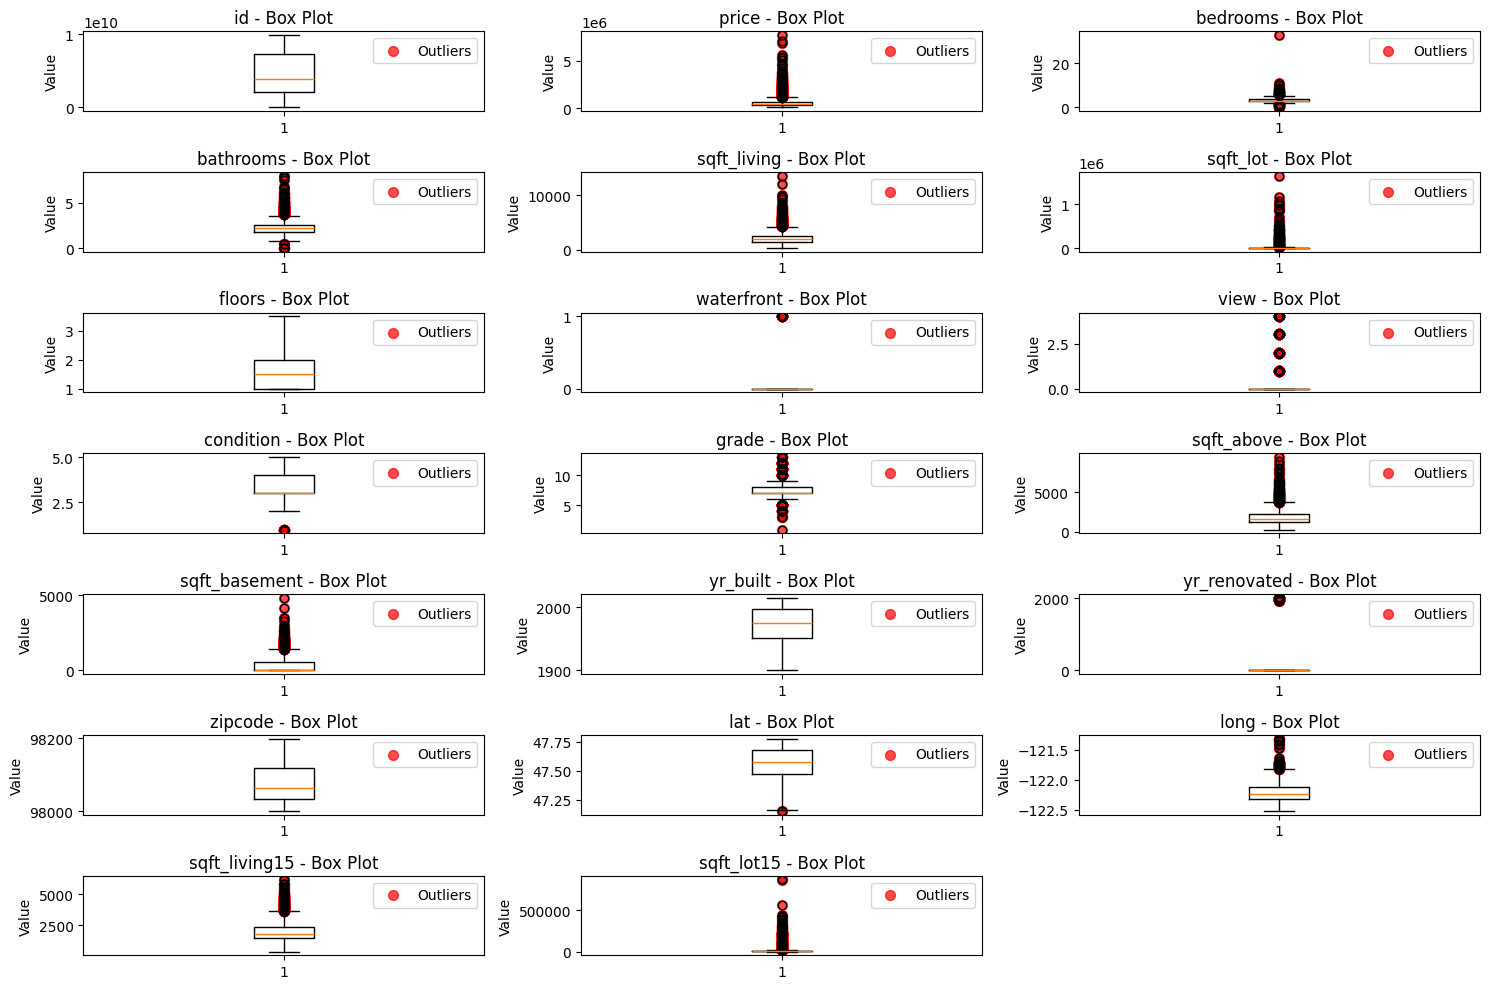

Column 'feature1' not found in numeric columns
Original dataset size: 21613
Cleaned dataset size: 18702
Removed 2911 outliers (13.47%)

To use with your own data:
1. Replace the sample data with: detector = OutlierDetector('your_file.csv')
2. Or use: detector = OutlierDetector(your_dataframe)
3. Run: results = detector.summary_report()
4. Visualize: detector.plot_outliers()


In [11]:
df = data
    
# Initialize detector
detector = OutlierDetector(df)

# Generate report
results = detector.summary_report()

# Plot outliers
detector.plot_outliers(method='iqr')

# Plot specific column
detector.plot_distribution_with_outliers('feature1', method='iqr')

# Remove outliers
df_clean = detector.remove_outliers(method='zscore')

print("\nTo use with your own data:")
print("1. Replace the sample data with: detector = OutlierDetector('your_file.csv')")
print("2. Or use: detector = OutlierDetector(your_dataframe)")
print("3. Run: results = detector.summary_report()")
print("4. Visualize: detector.plot_outliers()")

In [7]:
df_clean.to_csv("kc_house_data_outliers_dect.csv", index=False)